# Import Libraries

In [ ]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Reading Dataset

## ADRO

In [ ]:
url_adro = "https://raw.githubusercontent.com/MIlhamEr/Skripsi/refs/heads/main/dataset/PT%20Adaro%20Energy%20Indonesia%20Tbk_2020-2024.csv"
adro = pd.read_csv(url_adro)
adro.head()

Date    Open    High     Low   Close   Adj Close     Volume
0  2020-01-02  1555.0  1555.0  1490.0  1495.0  835.632202   76612000
1  2020-01-03  1460.0  1470.0  1425.0  1465.0  856.372375  117795600
2  2020-01-06  1455.0  1515.0  1450.0  1465.0  856.372375   61423200
3  2020-01-07  1480.0  1540.0  1460.0  1540.0  900.213867   74336500
4  2020-01-08  1530.0  1535.0  1505.0  1505.0  879.754395   55121100

In [ ]:
adro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1148 entries, 0 to 1147
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1148 non-null   object 
 1   Open       1148 non-null   float64
 2   High       1148 non-null   float64
 3   Low        1148 non-null   float64
 4   Close      1148 non-null   float64
 5   Adj Close  1148 non-null   float64
 6   Volume     1148 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 62.9+ KB


## DSSA

In [ ]:
url_dssa = "https://raw.githubusercontent.com/MIlhamEr/Skripsi/refs/heads/main/dataset/PT%20Dian%20Swastatika%20Sentosa%20Tbk_2020-2024.csv"
dssa = pd.read_csv(url_dssa)
dssa.head()

Date    Open    High     Low   Close  Adj Close  Volume
0  2020-01-02  1360.0  1435.0  1360.0  1435.0     1435.0    5000
1  2020-01-03  1435.0  1435.0  1435.0  1435.0     1435.0       0
2  2020-01-06  1437.5  1437.5  1435.0  1435.0     1435.0    3000
3  2020-01-07  1435.0  1435.0  1435.0  1435.0     1435.0       0
4  2020-01-08  1435.0  1435.0  1435.0  1435.0     1435.0       0

In [ ]:
dssa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1148 entries, 0 to 1147
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1148 non-null   object 
 1   Open       1148 non-null   float64
 2   High       1148 non-null   float64
 3   Low        1148 non-null   float64
 4   Close      1148 non-null   float64
 5   Adj Close  1148 non-null   float64
 6   Volume     1148 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 62.9+ KB


# Pre-processing Data

## Cleaning Dataset

In [ ]:
adro_missing = adro.isnull().sum()
dssa_missing = dssa.isnull().sum()

print("Missing values in ADRO:")
print(adro_missing)
print("\nMissing values in DSSA:")
print(dssa_missing)

Missing values in ADRO:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Missing values in DSSA:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


## Normalisasi Data

*   Normalisasi data pake MinMaxScaler
*   Kolom Date Ga dipake

In [ ]:
scaler = MinMaxScaler()

In [ ]:
def normalize_data(df):
    scaled_df = pd.DataFrame(scaler.fit_transform(df.iloc[:, 1:]), columns=df.columns[1:], index=df.index)
    return scaled_df

In [ ]:
adro_norm = adro.copy()
adro_norm = adro_norm.drop('Volume', axis=1)
adro_norm = normalize_data(adro_norm)
adro_norm.head()

Open      High       Low     Close  Adj Close
0  0.260372  0.247207  0.253602  0.243205   0.129805
1  0.233190  0.223464  0.234870  0.234621   0.135675
2  0.231760  0.236034  0.242075  0.234621   0.135675
3  0.238913  0.243017  0.244957  0.256080   0.148084
4  0.253219  0.241620  0.257925  0.246066   0.142293

In [ ]:
dssa_norm = dssa.copy()
dssa_norm = dssa_norm.drop('Volume', axis=1)
dssa_norm = normalize_data(dssa_norm)
dssa_norm.head()

Open      High       Low     Close  Adj Close
0  0.010859  0.011743  0.011073  0.012575   0.012575
1  0.012669  0.011743  0.012918  0.012575   0.012575
2  0.012729  0.011800  0.012918  0.012575   0.012575
3  0.012669  0.011743  0.012918  0.012575   0.012575
4  0.012669  0.011743  0.012918  0.012575   0.012575

## Windowing (Time Series Data)

Model GRU memerlukan data time series, jadi kita perlu membuat window (misalnya 30 hari ke belakang untuk memprediksi harga di hari ke-31).


In [ ]:
def prepare_data(df, time_step):
    X, y = [], []
    for i in range(len(df)-time_step):
        t = []
        for j in range(time_step):
            t.append(df.iloc[i + j].values)  # Use all columns for features
        X.append(t)
        y.append(df['High'][i + time_step]) # Predict High price
    return np.array(X), np.array(y)

# Data Mining

# ADRO


In [ ]:
time_step = 7
X_adro, y_adro = prepare_data(adro_norm, time_step)

In [ ]:
print(X_adro[0])
print(y_adro[0])

[[0.26037196 0.2472067  0.25360231 0.24320458 0.12980455]
 [0.23319027 0.22346369 0.23487032 0.23462089 0.13567503]
 [0.23175966 0.23603352 0.24207493 0.23462089 0.13567503]
 [0.23891273 0.24301676 0.24495677 0.25608011 0.1480843 ]
 [0.25321888 0.24162011 0.25792507 0.24606581 0.14229328]
 [0.25035765 0.23882682 0.24927954 0.24320458 0.14063873]
 [0.25035765 0.25       0.26080692 0.25894134 0.14973887]]
0.2583798882681564


## Target Attribute

Dipilih atribut "high" sebagai target prediksi

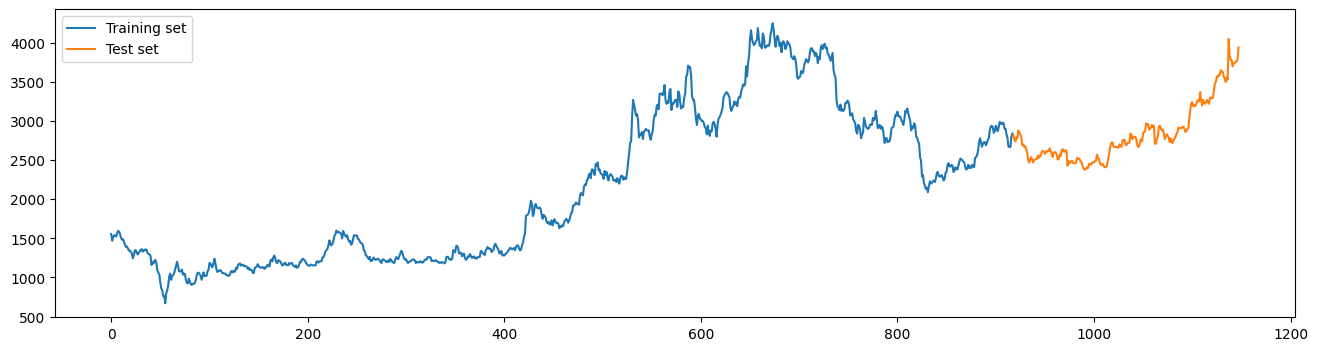

In [ ]:
adro["High"][:918].plot(figsize=(16,4),legend=True)
adro["High"][918:].plot(figsize=(16,4),legend=True)
plt.legend(['Training set','Test set'])
plt.show()

In [ ]:
X_train_adro, X_test_adro, y_train_adro, y_test_adro = train_test_split(X_adro, y_adro, test_size=0.2, random_state=42, shuffle=False)

## Training Model

In [ ]:
def create_gru_model(units):
    model = Sequential()
    model.add(GRU(units=units, return_sequences=True, input_shape=(X_train_adro.shape[1], X_train_adro.shape[2])))
    model.add(Dropout(0.2))
    model.add(GRU(units=units))
    model.add(Dropout(0.2))
    model.add(Dense(units=1)) # Output layer with 1 neuron for regression
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [ ]:
# Create model
gru_model = create_gru_model(50)  # Example: 50 GRU units

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model_gru_adro = create_gru_model(100)

start_time = time.time()
history = model_gru_adro.fit(X_train_adro, y_train_adro, epochs=100, batch_size=32, validation_split=0.1)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Waktu training: {elapsed_time:.2f} detik")

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.0577 - val_loss: 0.0021
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0045 - val_loss: 4.9115e-04
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0035 - val_loss: 9.7674e-04
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0028 - val_loss: 9.5480e-04
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0026 - val_loss: 9.4335e-04
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0028 - val_loss: 9.0496e-04
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0020 - val_loss: 4.3726e-04
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0019 - val_loss: 7.1848e-04
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0019 - val_loss: 0.0010
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0021 - val_loss: 6.9643e-04
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0020 - val_loss: 4.1383e-04
Epoch 12/100
26/

In [ ]:
model_gru_adro.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 7, 100)         │        32,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 100)            │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 278,405 (1.06 MB)

 Trainable params: 92,801 (362.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 185,604 (725.02 KB)

## Plot training history

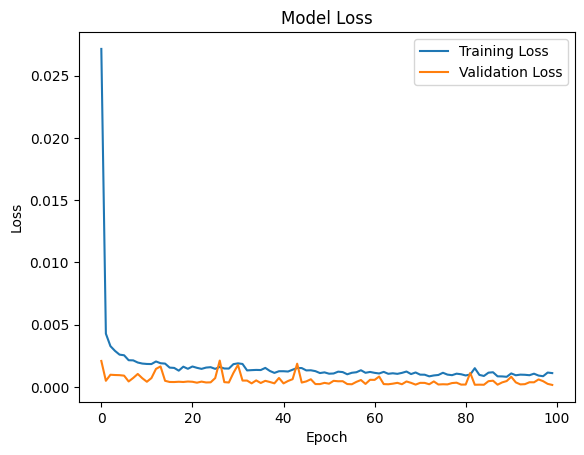

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

## Prediction

In [ ]:
y_pred_adro = model_gru_adro.predict(X_test_adro)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


# DSSA

In [ ]:
time_step = 7
X_dssa, y_dssa = prepare_data(dssa_norm, time_step)

## Target Attribute

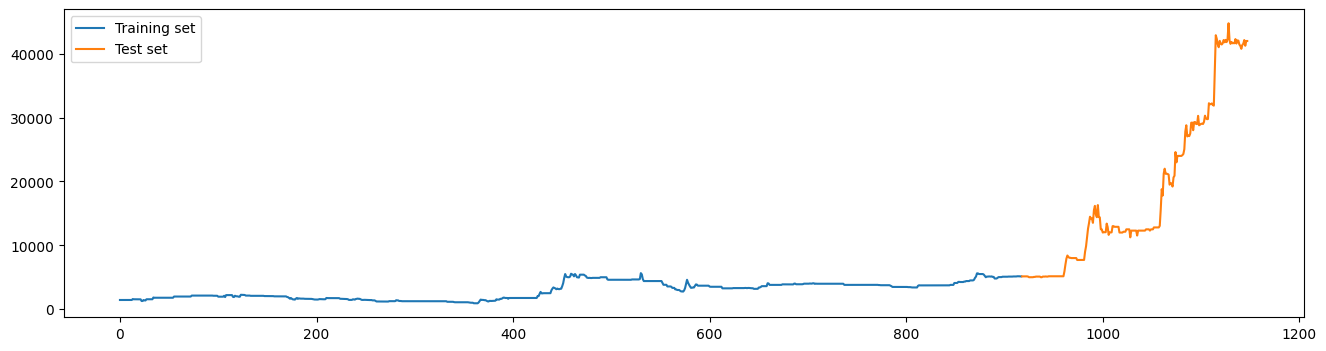

In [ ]:
dssa["High"][:918].plot(figsize=(16,4),legend=True)
dssa["High"][918:].plot(figsize=(16,4),legend=True)
plt.legend(['Training set','Test set'])
plt.show()

In [ ]:
X_train_dssa, X_test_dssa, y_train_dssa, y_test_dssa = train_test_split(X_dssa, y_dssa, test_size=0.2, random_state=42, shuffle=False)

## Training Model

In [ ]:
model_gru_dssa = create_gru_model(100)

start_time = time.time()
history = model_gru_dssa.fit(X_train_dssa, y_train_dssa, epochs=100, batch_size=32, validation_split=0.1)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Waktu training: {elapsed_time:.2f} detik")

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 0.0010 - val_loss: 1.3904e-05
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 7.0119e-05 - val_loss: 5.8614e-05
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.6273e-05 - val_loss: 1.6406e-05
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.0979e-05 - val_loss: 1.1849e-05
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.4063e-05 - val_loss: 1.4732e-05
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.5219e-05 - val_loss: 1.4240e-05
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.9691e-05 - val_loss: 1.1127e-05
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.6204e-05 - val_loss: 1.0614e-05
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 2.8645e-05 - val_loss: 1.0287e-05
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 2.2182e-05 - val_loss: 1.0952e-05
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 2.4807e-05 - v

In [ ]:
model_gru_dssa.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                     │ (None, 7, 100)         │        32,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 100)            │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 278,405 (1.06 MB)

 Trainable params: 92,801 (362.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 185,604 (725.02 KB)

## Plot training history

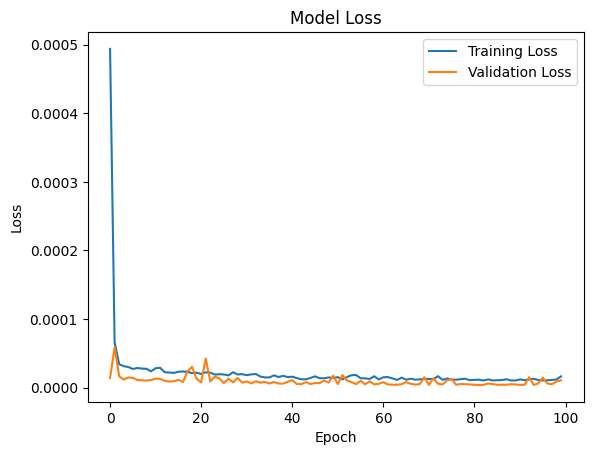

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

##Prediction

In [ ]:
y_pred_dssa = model_gru_dssa.predict(X_test_dssa)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


# Evaluasi Model

In [ ]:
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)

    print(f'RMSE: {rmse:.3f}')
    print(f'MAPE: {mape:.3f}%')
    print(f'R-squared: {r2:.5f}')

    return rmse, mape, r2

In [ ]:
# Evaluate ADRO model
print("Evaluation for ADRO:")
rmse_adro, mape_adro, r2_adro = evaluate_model(y_test_adro, y_pred_adro)

# Evaluate DSSA model
print("\nEvaluation for DSSA:")
rmse_dssa, mape_dssa, r2_dssa = evaluate_model(y_test_dssa, y_pred_dssa)

Evaluation for ADRO:
RMSE: 0.015
MAPE: 17.732%
R-squared: 0.97978

Evaluation for DSSA:
RMSE: 0.024
MAPE: 119.468%
R-squared: 0.99261


# Invert

##ADRO

In [ ]:
dummy_input_adro = np.zeros((len(y_pred_adro), 5))
dummy_input_adro[:, 1] = y_pred_adro.reshape(-1)
dummy_input_adro

array([[0.        , 0.59867561, 0.        , 0.        , 0.        ],
       [0.        , 0.58274603, 0.        , 0.        , 0.        ],
       [0.        , 0.58338583, 0.        , 0.        , 0.        ],
       ...,
       [0.        , 0.86513734, 0.        , 0.        , 0.        ],
       [0.        , 0.85737336, 0.        , 0.        , 0.        ],
       [0.        , 0.87373042, 0.        , 0.        , 0.        ]])

In [ ]:
inverted_adro = scaler.inverse_transform(dummy_input_adro)
pred_lstm_adro_real = inverted_adro[:, 1]
pred_lstm_adro_real = pred_lstm_adro_real / 10
pred_lstm_adro_real

array([2717.49188167, 2647.63270974, 2650.43853623, 2710.21827185,
       2705.91203135, 2778.27799255, 2775.82139134, 2752.89119655,
       2638.51756391, 2596.12773126, 2596.56739962, 2568.30681413,
       2564.34927613, 2476.62628996, 2455.55566752, 2320.5304305 ,
       2284.42416967, 2353.0415791 , 2400.62430805, 2348.04342294,
       2313.68263504, 2329.64923587, 2350.93681714, 2354.59557933,
       2359.07904643, 2397.5633589 , 2400.07589889, 2414.65683863,
       2430.57534257, 2484.84563112, 2486.43361285, 2458.59204543,
       2438.57275838, 2451.84384191, 2480.54487994, 2481.09485748,
       2510.52989596, 2484.13672471, 2472.22646964, 2422.3499893 ,
       2417.35496989, 2434.01453197, 2461.70945615, 2461.09726632,
       2443.55052564, 2348.40728641, 2365.10318255, 2405.46248975,
       2396.72479999, 2488.95504031, 2489.36307973, 2495.19796503,
       2490.23300618, 2497.44126695, 2484.13149679, 2298.10995823,
       2357.33239722, 2295.34020442, 2325.81011033, 2322.15788

## DSSA

In [ ]:
dummy_input_dssa = np.zeros((len(y_pred_dssa), 5))
dummy_input_dssa[:, 1] = y_pred_dssa.reshape(-1)
dummy_input_dssa

array([[0.        , 0.09904999, 0.        , 0.        , 0.        ],
       [0.        , 0.09905533, 0.        , 0.        , 0.        ],
       [0.        , 0.09918468, 0.        , 0.        , 0.        ],
       ...,
       [0.        , 0.9006694 , 0.        , 0.        , 0.        ],
       [0.        , 0.89220369, 0.        , 0.        , 0.        ],
       [0.        , 0.91206467, 0.        , 0.        , 0.        ]])

In [ ]:
inverted_dssa = scaler.inverse_transform(dummy_input_dssa)
pred_lstm_dssa_real = inverted_dssa[:, 1]
pred_lstm_dssa_real

array([ 5263.8371101 ,  5264.07171316,  5269.74433679,  5268.91211674,
        5271.91686571,  5273.37186214,  5225.44944886,  5114.65700909,
        5130.53976711,  5132.36659959,  5139.50336851,  5139.12957199,
        5190.44882849,  5183.42315294,  5242.03078814,  5234.8368388 ,
        5232.02584974,  5231.58082277,  5232.26339351,  5117.61764746,
        5132.92206645,  5249.03587874,  5234.87114705,  5233.96769654,
        5238.90612368,  5231.81150489,  5233.66839793,  5291.66175213,
        5284.19725776,  5283.88292886,  5283.44247632,  5283.55160922,
        5283.76726106,  5283.91658362,  5283.91658362,  5283.91658362,
        5283.91658362,  5283.91658362,  5283.91658362,  5283.91658362,
        5283.91658362,  5283.91658362,  5283.91658362,  6176.65867418,
        7240.93971387,  8174.00052987,  8435.96588969,  8140.279117  ,
        8097.96103761,  7920.85663728,  8137.76448585,  8143.8419468 ,
        8139.52956349,  8137.32534029,  8135.38316675,  8135.99810123,
      

# Simpan Prediksi

In [ ]:
adro_actual = adro['High'].iloc[919:]
dssa_actual = dssa['High'].iloc[919:]

In [ ]:
# Create dataframes for predictions
df_pred_adro = pd.DataFrame({'Actual ADRO': adro_actual.values, 'Predicted ADRO': pred_lstm_adro_real.flatten()})
df_pred_dssa = pd.DataFrame({'Actual DSSA': dssa_actual.values, 'Predicted DSSA': pred_lstm_dssa_real.flatten()})

In [ ]:
df_pred_adro.tail()

Actual ADRO  Predicted ADRO
224       3740.0     3844.406319
225       3760.0     3855.139246
226       3760.0     3886.059799
227       3780.0     3852.010856
228       3940.0     3923.744762

In [ ]:
df_pred_dssa.tail()

Actual DSSA  Predicted DSSA
224      41575.0    40659.793050
225      42150.0    40667.242841
226      41250.0    40418.856358
227      42000.0    40047.592764
228      42000.0    40918.596169

In [ ]:
# Save predictions to CSV files
df_pred_adro.to_csv('GRU_adro_predictions.csv', index=False)
df_pred_dssa.to_csv('GRU_dssa_predictions.csv', index=False)

print("ADRO predictions saved to 'GRU_adro_predictions.csv'")
print("DSSA predictions saved to 'GRU_dssa_predictions.csv'")

ADRO predictions saved to 'GRU_adro_predictions.csv'
DSSA predictions saved to 'GRU_dssa_predictions.csv'


In [ ]:
# prompt: downloadkan csv adro dan dssa tersebut

from google.colab import files

files.download('GRU_adro_predictions.csv')
files.download('GRU_dssa_predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>